In [ ]:
!pip install yfinance gudhi matplotlib numpy pandas
!pip install giotto-tda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.4/526.4 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.3 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import gudhi as gd
import matplotlib.pyplot as plt
from gudhi import RipsComplex, SimplexTree
from gudhi.hera import wasserstein_distance

# -------------------------------
# Data Acquisition and Preparation
# -------------------------------
sp500 = yf.download('^GSPC', start='2005-01-01', end='2023-07-30')['Close']
nasdaq = yf.download('^IXIC', start='2005-01-01', end='2023-07-30')['Close']
djia = yf.download('^DJI', start='2005-01-01', end='2023-07-30')['Close']
russell2000 = yf.download('^RUT', start='2005-01-01', end='2023-07-30')['Close']

log_returns_sp500 = np.log(sp500 / sp500.shift(1)).dropna()
log_returns_nasdaq = np.log(nasdaq / nasdaq.shift(1)).dropna()
log_returns_djia = np.log(djia / djia.shift(1)).dropna()
log_returns_russell2000 = np.log(russell2000 / russell2000.shift(1)).dropna()

# -------------------------------
# Sliding Window Approach
# -------------------------------
window_size = 50
persistence_diagrams = []
p_persistence_diagrams = []
wasserstein_distances = []


# Helper Functions
def simplex_tree_to_diagram(simplex_tree):
    return np.array([[birth, death] for _, (birth, death) in simplex_tree.persistence() if death != float('inf')])

def compute_wasserstein_distance(diagram1, diagram2):
    return gd.hera.wasserstein_distance(diagram1, diagram2, order=2)


# Main Analysis Loop
for i in range(len(log_returns_sp500) - window_size + 1):
    window = np.column_stack((log_returns_sp500[i:i+window_size],
                              log_returns_nasdaq[i:i+window_size],
                              log_returns_djia[i:i+window_size],
                              log_returns_russell2000[i:i+window_size]))
    rips = RipsComplex(points=window, max_edge_length=10)
    simplex_tree = rips.create_simplex_tree(max_dimension=2)
    diagram = simplex_tree.persistence()
    persistence_diagrams.append(diagram)
    p_persistence_diagrams.append(simplex_tree_to_diagram(simplex_tree))

# Compute Wasserstein distances
for i in range(len(persistence_diagrams) - 1):
    distance = compute_wasserstein_distance(p_persistence_diagrams[i], p_persistence_diagrams[i+1])
    wasserstein_distances.append(distance)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import gudhi as gd
import matplotlib.pyplot as plt
from gudhi import RipsComplex, SimplexTree
from gudhi.hera import wasserstein_distance

# -------------------------------
# Data Acquisition and Preparation
# -------------------------------
sp500 = yf.download('^GSPC', start='2005-01-01', end='2023-07-30')['Close']
nasdaq = yf.download('^IXIC', start='2005-01-01', end='2023-07-30')['Close']
djia = yf.download('^DJI', start='2005-01-01', end='2023-07-30')['Close']
russell2000 = yf.download('^RUT', start='2005-01-01', end='2023-07-30')['Close']

log_returns_sp500 = np.log(sp500 / sp500.shift(1)).dropna()
log_returns_nasdaq = np.log(nasdaq / nasdaq.shift(1)).dropna()
log_returns_djia = np.log(djia / djia.shift(1)).dropna()
log_returns_russell2000 = np.log(russell2000 / russell2000.shift(1)).dropna()

# -------------------------------
# Sliding Window Approach
# -------------------------------
window_size = 50
persistence_diagrams = []
landscapes = []

# Helper Functions
def create_landscape_function(b, d):
    return lambda x: max(min(x - b, d - x, (d - b) / 2), 0)

def calculate_lp_norm(landscape, p):
    return np.sum(np.abs(landscape)**p)**(1/p)

def rate_of_change(values):
    return np.diff(values)

# Main Analysis Loop
for i in range(len(log_returns_sp500) - window_size + 1):
    window = np.column_stack((log_returns_sp500[i:i+window_size],
                              log_returns_nasdaq[i:i+window_size],
                              log_returns_djia[i:i+window_size],
                              log_returns_russell2000[i:i+window_size]))
    rips = RipsComplex(points=window, max_edge_length=10)
    simplex_tree = rips.create_simplex_tree(max_dimension=2)
    diagram = simplex_tree.persistence()
    persistence_diagrams.append(diagram)


    # Extract 1-cycles for landscape functions
    one_cycles = [pt for pt in diagram if pt[0] == 1]
    if one_cycles:
        landscape_functions = [create_landscape_function(b, d) for _, (b, d) in one_cycles]
        x_values = np.linspace(min(b for _, (b, _) in one_cycles),
                               max(d for _, (_, d) in one_cycles),
                               1000)
        landscape_values = np.maximum.reduce([np.array([f(x) for x in x_values]) for f in landscape_functions])
    else:
        x_values = np.linspace(0, 1, 1000)
        landscape_values = np.zeros_like(x_values)

    landscapes.append(landscape_values)

# Compute L^p norms
lp_norms_p1 = [calculate_lp_norm(landscape, 1) for landscape in landscapes]
lp_norms_p2 = [calculate_lp_norm(landscape, 2) for landscape in landscapes]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


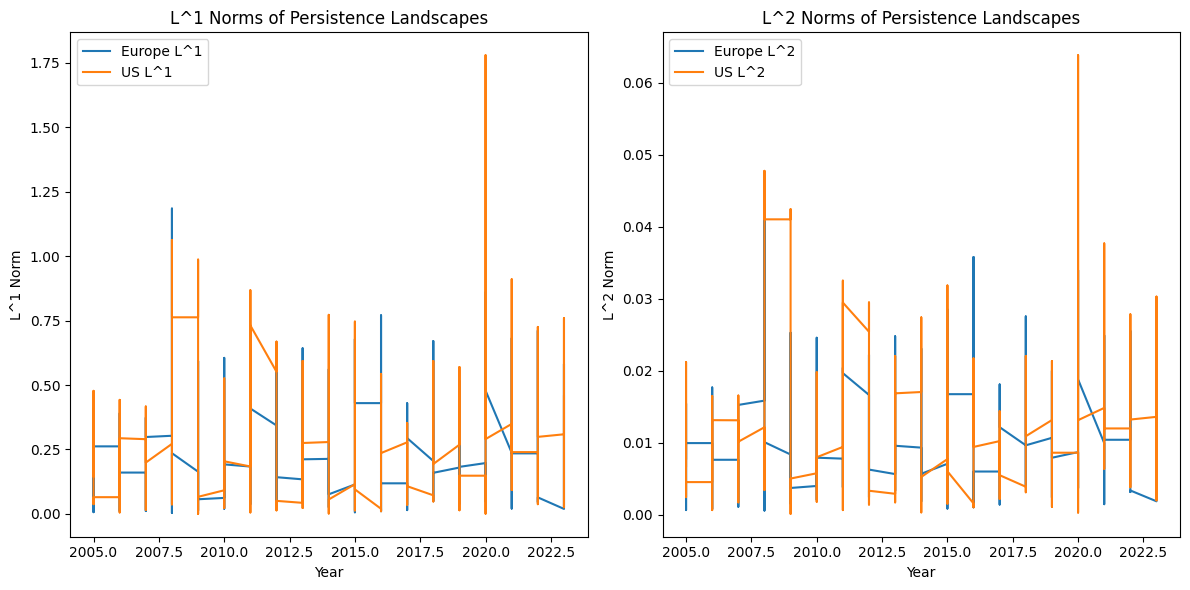

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gudhi import RipsComplex, SimplexTree

# Function to download and compute log returns
def download_and_compute_log_returns(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)['Close']
    return np.log(data / data.shift(1)).dropna()

# Tickers for indices
indices_tickers = {
    'SP500': '^GSPC', 'NASDAQ': '^IXIC', 'DJIA': '^DJI', 'RUS2000': '^RUT',
    'DAX': '^GDAXI', 'CAC40': '^FCHI', 'FTSE100': '^FTSE'
}

# Download data and compute log returns for each index
log_returns = {}
for index, ticker in indices_tickers.items():
    log_returns[index] = download_and_compute_log_returns(ticker, '2005-01-01', '2023-07-30')

# Combine log returns for European and American indices
log_returns_europe = pd.concat([log_returns['DAX'], log_returns['CAC40'], log_returns['FTSE100']], axis=1).dropna()
log_returns_us = pd.concat([log_returns['SP500'], log_returns['NASDAQ'], log_returns['DJIA'], log_returns['RUS2000']], axis=1).dropna()

# Function to create a landscape function for a single point
def create_landscape_function(b, d):
    return lambda x: max(min(x - b, d - x, (d - b) / 2), 0)

# Function to calculate L^p norm of a landscape
def calculate_lp_norm(landscape, p):
    return np.sum(np.abs(landscape)**p)**(1/p)

# Sliding Window Approach and TDA
window_size = 50
landscapes_europe = []
landscapes_us = []
window_dates = []

# Iterate over each sliding window
for i in range(len(log_returns['SP500']) - window_size + 1):
    window_europe = log_returns_europe[i:i+window_size]
    window_us = log_returns_us[i:i+window_size]
    point_cloud_europe = window_europe.values
    point_cloud_us = window_us.values

    # TDA using Rips Complex for Europe
    rips_europe = RipsComplex(points=point_cloud_europe, max_edge_length=10)
    simplex_tree_europe = rips_europe.create_simplex_tree(max_dimension=2)
    diagram_europe = simplex_tree_europe.persistence()

    # TDA using Rips Complex for US
    rips_us = RipsComplex(points=point_cloud_us, max_edge_length=10)
    simplex_tree_us = rips_us.create_simplex_tree(max_dimension=2)
    diagram_us = simplex_tree_us.persistence()

    # Extract 1-cycles and compute landscapes for Europe
    one_cycles_europe = [pt for pt in diagram_europe if pt[0] == 1]
    if one_cycles_europe:
        landscape_functions_europe = [create_landscape_function(b, d) for _, (b, d) in one_cycles_europe]
        x_values_europe = np.linspace(min(b for _, (b, _) in one_cycles_europe), max(d for _, (_, d) in one_cycles_europe), 1000)
        landscape_values_europe = np.maximum.reduce([np.array([f(x) for x in x_values_europe]) for f in landscape_functions_europe])
    else:
        x_values_europe = np.linspace(0, 1, 1000)
        landscape_values_europe = np.zeros_like(x_values_europe)
    landscapes_europe.append(landscape_values_europe)

    # Extract 1-cycles and compute landscapes for US
    one_cycles_us = [pt for pt in diagram_us if pt[0] == 1]
    if one_cycles_us:
        landscape_functions_us = [create_landscape_function(b, d) for _, (b, d) in one_cycles_us]
        x_values_us = np.linspace(min(b for _, (b, _) in one_cycles_us), max(d for _, (_, d) in one_cycles_us), 1000)
        landscape_values_us = np.maximum.reduce([np.array([f(x) for x in x_values_us]) for f in landscape_functions_us])
    else:
        x_values_us = np.linspace(0, 1, 1000)
        landscape_values_us = np.zeros_like(x_values_us)
    landscapes_us.append(landscape_values_us)

    window_dates.append(log_returns['SP500'].index[i + window_size - 1])

# Convert window dates to years for plotting
window_years = [date.year for date in window_dates]

# Calculate L^p norms
lp_norms_p1_europe = [calculate_lp_norm(landscape, 1) for landscape in landscapes_europe]
lp_norms_p2_europe = [calculate_lp_norm(landscape, 2) for landscape in landscapes_europe]
lp_norms_p1_us = [calculate_lp_norm(landscape, 1) for landscape in landscapes_us]
lp_norms_p2_us = [calculate_lp_norm(landscape, 2) for landscape in landscapes_us]

# Plotting L^1 and L^2 norms
plt.figure(figsize=(12, 6))

# L^1 Norms
plt.subplot(1, 2, 1)
plt.plot(window_years, lp_norms_p1_europe, label='Europe L^1')
plt.plot(window_years, lp_norms_p1_us, label='US L^1')
plt.title("L^1 Norms of Persistence Landscapes")
plt.xlabel("Year")
plt.ylabel("L^1 Norm")
plt.legend()

# L^2 Norms
plt.subplot(1, 2, 2)
plt.plot(window_years, lp_norms_p2_europe, label='Europe L^2')
plt.plot(window_years, lp_norms_p2_us, label='US L^2')
plt.title("L^2 Norms of Persistence Landscapes")
plt.xlabel("Year")
plt.ylabel("L^2 Norm")
plt.legend()

plt.tight_layout()
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


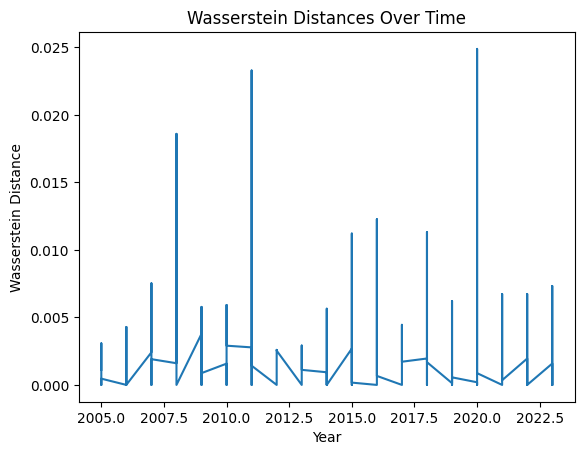

In [ ]:
import yfinance as yf
import networkx as nx
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt
from gudhi import RipsComplex, SimplexTree
from gudhi.hera import wasserstein_distance


# -------------------------------
# Data Acquisition and Preparation
# -------------------------------
sp500 = yf.download('^GSPC', start='2005-01-01', end='2023-07-30')['Close']
nasdaq = yf.download('^IXIC', start='2005-01-01', end='2023-07-30')['Close']
djia = yf.download('^DJI', start='2005-01-01', end='2023-07-30')['Close']
russell2000 = yf.download('^RUT', start='2005-01-01', end='2023-07-30')['Close']

log_returns_sp500 = np.log(sp500 / sp500.shift(1)).dropna()
log_returns_nasdaq = np.log(nasdaq / nasdaq.shift(1)).dropna()
log_returns_djia = np.log(djia / djia.shift(1)).dropna()
log_returns_russell2000 = np.log(russell2000 / russell2000.shift(1)).dropna()

# -------------------------------
# Sliding Window Approach
# -------------------------------
window_size = 50

# Helper Functions
def simplex_tree_to_diagram(simplex_tree):
    return np.array([[birth, death] for _, (birth, death) in simplex_tree.persistence() if death != float('inf')])

def compute_wasserstein_distance(diagram1, diagram2):
    return gd.hera.wasserstein_distance(diagram1, diagram2, order=2)


def create_graph_from_window(window):
    graph = nx.Graph()
    num_points = window.shape[0]
    for i in range(num_points):
        for j in range(i + 1, num_points):
            distance = np.linalg.norm(window[i] - window[j])
            graph.add_edge(i, j, weight=distance)
    return graph

def combine_graphs(G1, G2):
    G = nx.Graph()

    # Add original and corresponding vertices
    for i in G1.nodes():
        G.add_node(i)        # Original vertex
        G.add_node(f"{i}'")  # Corresponding vertex

    # Unique vertex O
    G.add_node('O')

    # Assigning weights
    for i, j in G1.edges():
        w1 = G1[i][j]['weight']
        w2 = G2[i][j]['weight'] if (i, j) in G2.edges() or (j, i) in G2.edges() else float('inf')

        # Add edges between original vertices and their corresponding vertices
        G.add_edge(i, f"{i}'", weight=0)       # Weight = 0
        G.add_edge(i, f"{j}'", weight=w1)      # Weight = w1
        G.add_edge(f"{i}'", f"{j}'", weight=min(w1, w2)) # Minimum weight

        # Add edges involving unique vertex O
        G.add_edge('O', i, weight=0)               # Weight = 0
        G.add_edge('O', f"{i}'", weight=float('inf'))  # Weight = + infinity

    return G

def graph_to_distance_matrix(G):
    n = len(G.nodes())
    distance_matrix = np.full((n, n), np.inf)
    for i, j, data in G.edges(data=True):
        distance = data['weight']
        distance_matrix[i, j] = distance_matrix[j, i] = distance
    return distance_matrix

def compute_persistence_diagram(graph):
    distance_matrix = nx.floyd_warshall_numpy(graph)
    rips_complex = gd.RipsComplex(distance_matrix=distance_matrix, max_edge_length=np.inf)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    return simplex_tree.persistence()

def compute_p_persistence_diagram(graph):
    distance_matrix = nx.floyd_warshall_numpy(graph)
    rips_complex = gd.RipsComplex(distance_matrix=distance_matrix, max_edge_length=np.inf)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    return simplex_tree_to_diagram(simplex_tree)


# Analysis Loop
graphs = []
persistence_diagrams = []
p_persistence_diagrams = []
wasserstein_distances = []
window_dates = []

for i in range(len(log_returns_sp500) - window_size + 1):
    window = np.column_stack((log_returns_sp500[i:i+window_size],
                              log_returns_nasdaq[i:i+window_size],
                              log_returns_djia[i:i+window_size],
                              log_returns_russell2000[i:i+window_size]))
    graph = create_graph_from_window(window)
    graphs.append(graph)
    window_dates.append(sp500.index[i + window_size - 1])

# Compute combined graphs and persistence diagrams
for i in range(len(graphs) - 1):
    combined_graph = combine_graphs(graphs[i], graphs[i + 1])
    pd = compute_persistence_diagram(combined_graph)
    p_pd = compute_p_persistence_diagram(combined_graph)
    persistence_diagrams.append(pd)
    p_persistence_diagrams.append(p_pd)

# Compute Wasserstein distances
for i in range(len(persistence_diagrams) - 1):
    distance = gd.hera.wasserstein_distance(p_persistence_diagrams[i], p_persistence_diagrams[i + 1], order=2)
    wasserstein_distances.append(distance)

# Plot Wasserstein distances over time
years = [date.year for date in window_dates[1:-1]]  # Skip first and last year as they don't have complete data
plt.plot(years, wasserstein_distances)
plt.xlabel('Year')
plt.ylabel('Wasserstein Distance')
plt.title('Wasserstein Distances Over Time')
plt.show()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 10.6 MB/s eta 0:00:00
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


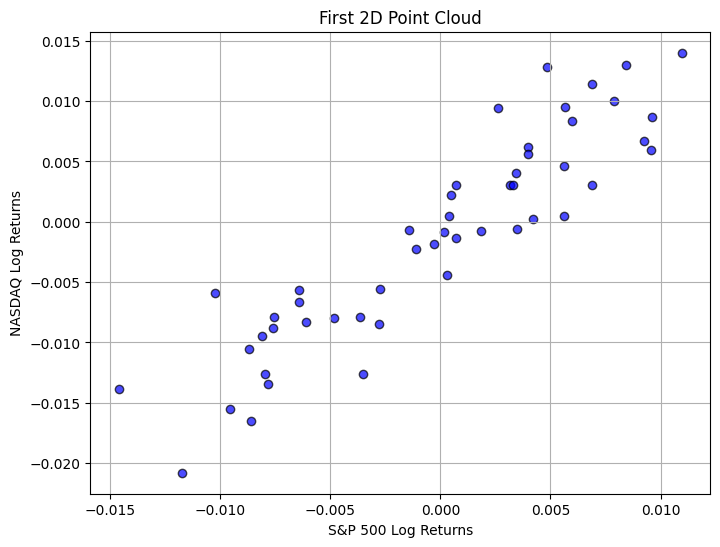

<Figure size 800x600 with 0 Axes>

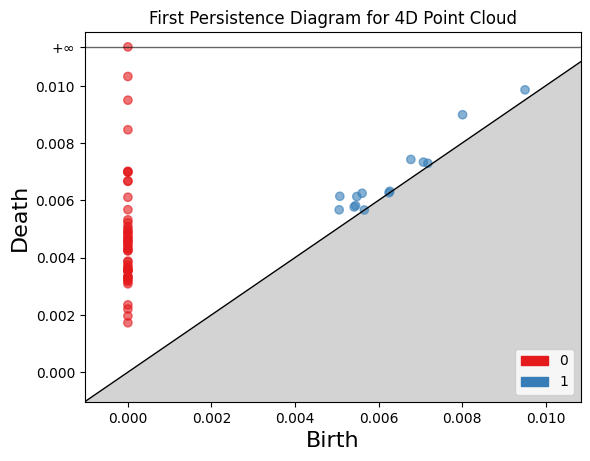

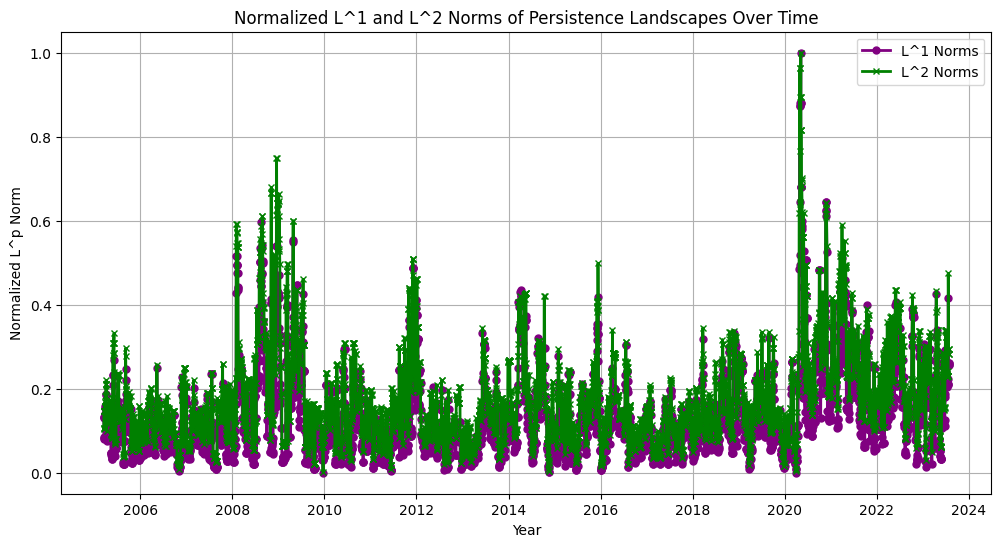

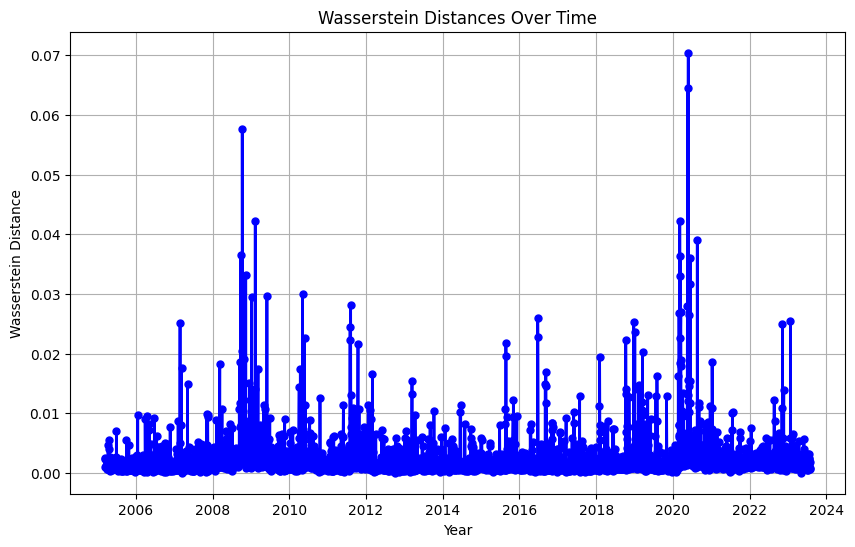

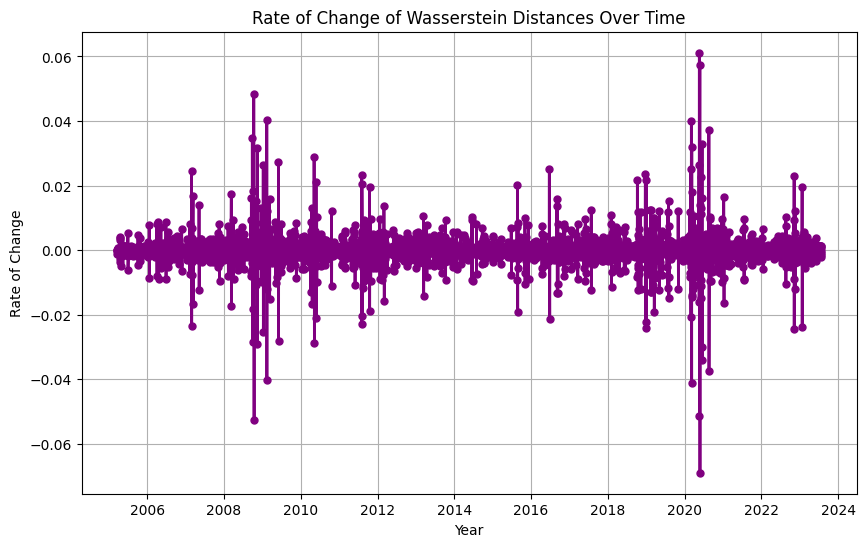

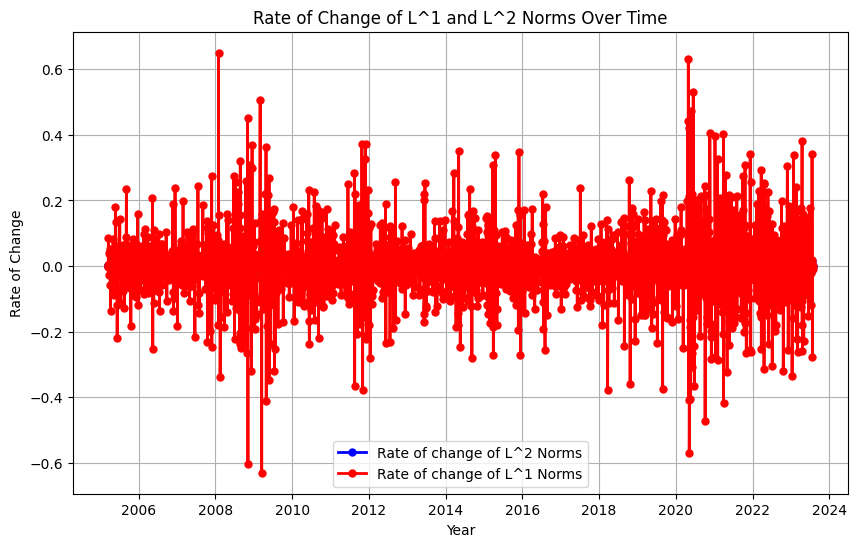

In [1]:
!pip install yfinance gudhi matplotlib numpy pandas

import yfinance as yf # used for index data
import numpy as np # used for arrays and computations with them
import pandas as pd # used to manipulate and clean data obtained from yf
import gudhi as gd # used to to the TDA
import matplotlib.pyplot as plt # used to plot graphs
from gudhi import RipsComplex, SimplexTree
from gudhi.hera import wasserstein_distance

# -------------------------------
# Data Acquisition and Preparation (download index data from yfinance as pandas dataframe and only take close data (the raw data will have colums 'close','open','high'...))
# -------------------------------
sp500 = yf.download('^GSPC', start='2005-01-01', end='2023-07-30')['Close']
nasdaq = yf.download('^IXIC', start='2005-01-01', end='2023-07-30')['Close']
djia = yf.download('^DJI', start='2005-01-01', end='2023-07-30')['Close']
russell2000 = yf.download('^RUT', start='2005-01-01', end='2023-07-30')['Close']

log_returns_sp500 = np.log(sp500 / sp500.shift(1)).dropna() # use pandas methods .shift() to divide by previous entry in table, this creates some NaN values so we remove them with .dropna()
log_returns_nasdaq = np.log(nasdaq / nasdaq.shift(1)).dropna()
log_returns_djia = np.log(djia / djia.shift(1)).dropna()
log_returns_russell2000 = np.log(russell2000 / russell2000.shift(1)).dropna()

# -------------------------------
# Sliding Window Approach
# -------------------------------
window_size = 50
persistence_diagrams = [] # persistece diagram is a collection of points where points are of the form (dim , (birth,death))
p_persistence_diagrams = [] # numpy array of persistence diagrams used to calculate wasserstein distances
wasserstein_distances = [] #values of wasserstein distances (real float values)
landscapes = [] # stores the values that the landscape fucntion takes for a specified  range (1000 values are stored for each landscape function)
window_dates = [] #stores the dates in form YYYY-MM-DD i.e. in pandas.Timestamp form

# Helper Functions
def simplex_tree_to_diagram(simplex_tree): #converts a persistence diagram to numpy array
    return np.array([[birth, death] for _, (birth, death) in simplex_tree.persistence() if death != float('inf')])

def compute_wasserstein_distance(diagram1, diagram2):
    return gd.hera.wasserstein_distance(diagram1, diagram2, order=2)

def create_landscape_function(b, d):
    return lambda x: max(min(x - b, d - x, (d - b) / 2), 0)

def calculate_lp_norm(landscape, p):
    return np.sum(np.abs(landscape)**p)**(1/p)

def rate_of_change(values): # if we have a list [a,b,c,d,...] .diff(list)=[b-a,c-b,d-c,...]
    return np.diff(values)

# Main Analysis Loop
for i in range(len(log_returns_sp500) - window_size + 1):
    window = np.column_stack((log_returns_sp500[i:i+window_size],
                              log_returns_nasdaq[i:i+window_size],
                              log_returns_djia[i:i+window_size],
                              log_returns_russell2000[i:i+window_size])) #creates a matrix 4x50 with vectors daily returns of indices over the 50 days in the given window
    rips = RipsComplex(points=window, max_edge_length=10) #crates a rips complex with max edge length 10
    simplex_tree = rips.create_simplex_tree(max_dimension=2) # creates a simplex tree with no faces of dim higher than 2
    diagram = simplex_tree.persistence() # creates the persistence diagram
    persistence_diagrams.append(diagram) # adds persistence diagram to list perisistence_diagrams used to compute landscapes
    p_persistence_diagrams.append(simplex_tree_to_diagram(simplex_tree)) # adds persistence diagram as numpy array to list p_persistence diagrams used to compute wasseerstein distances


    # Extract 1-cycles for landscape functions
    one_cycles = [pt for pt in diagram if pt[0] == 1]
    if one_cycles:
        landscape_functions = [create_landscape_function(b, d) for _, (b, d) in one_cycles]
        x_values = np.linspace(min(b for _, (b, _) in one_cycles),
                               max(d for _, (_, d) in one_cycles),
                               1000)
        landscape_values = np.maximum.reduce([np.array([f(x) for x in x_values]) for f in landscape_functions]) #overlays landscapes and takes pointwise max
    else:# if no one cycles
        x_values = np.linspace(0, 1, 1000) # Default range
        landscape_values = np.zeros_like(x_values)

    landscapes.append(landscape_values)
    window_dates.append(sp500.index[i + window_size - 1]) #stores date as pandas.Timestamp YYYY-MM-DD


# Compute Wasserstein distances and L^p norms
for i in range(len(persistence_diagrams) - 1):
    distance = compute_wasserstein_distance(p_persistence_diagrams[i], p_persistence_diagrams[i+1])
    wasserstein_distances.append(distance)

lp_norms_p1 = [calculate_lp_norm(landscape, 1) for landscape in landscapes]
lp_norms_p2 = [calculate_lp_norm(landscape, 2) for landscape in landscapes]

# -------------------------------
# Visualization
# -------------------------------
# First 2D Point Cloud
plt.figure(figsize=(8, 6))
plt.scatter(log_returns_sp500[:window_size], log_returns_nasdaq[:window_size], c='blue', edgecolor='k', alpha=0.7)
plt.xlabel('S&P 500 Log Returns')
plt.ylabel('NASDAQ Log Returns')
plt.title('First 2D Point Cloud')
plt.grid(True)
plt.show()

# First Persistence Diagram for 4D Point Cloud
plt.figure(figsize=(8, 6))
gd.plot_persistence_diagram(persistence_diagrams[0])
plt.title('First Persistence Diagram for 4D Point Cloud')
plt.xlabel('Birth')
plt.ylabel('Death')
plt.show()

# Normalized L^p Norms Over Time
window_years = [date.year for date in window_dates]
normalized_lp_norms_p1 = [norm / max(lp_norms_p1) for norm in lp_norms_p1]
normalized_lp_norms_p2 = [norm / max(lp_norms_p2) for norm in lp_norms_p2]

# Plotting L^1 and L^2 Norms Over Time
plt.figure(figsize=(12, 6))
plt.plot(window_dates, normalized_lp_norms_p1, label='L^1 Norms', color='purple', marker='o', linewidth=2, markersize=5)
plt.plot(window_dates, normalized_lp_norms_p2, label='L^2 Norms', color='green', marker='x', linewidth=2, markersize=5)
plt.title("Normalized L^1 and L^2 Norms of Persistence Landscapes Over Time")
plt.xlabel("Year")
plt.ylabel("Normalized L^p Norm")
plt.legend()
plt.grid(True)
plt.show()

# Plotting Wasserstein distances over time
plt.figure(figsize=(10, 6))
plt.plot(window_dates[1:], wasserstein_distances, color='blue', marker='o', linestyle='-', linewidth=2, markersize=5)
plt.xlabel('Year')
plt.ylabel('Wasserstein Distance')
plt.title('Wasserstein Distances Over Time')
plt.grid(True)
plt.show()

# Calculate rate of change for Wasserstein distances and L^2 norms
rate_of_change_wasserstein = rate_of_change(wasserstein_distances)
rate_of_change_lp1 = rate_of_change(lp_norms_p1)
rate_of_change_lp2 = rate_of_change(lp_norms_p2)

# Adjust years_for_rate_of_change to match the length of the rate of change arrays
years_for_rate_of_change = window_years[2:]  # Start from the third year

# Plotting Rate of Change of Wasserstein Distances
plt.figure(figsize=(10, 6))
plt.plot(window_dates[2:], rate_of_change_wasserstein, color='purple', marker='o', linestyle='-', linewidth=2, markersize=5)
plt.title("Rate of Change of Wasserstein Distances Over Time")
plt.xlabel("Year")
plt.ylabel("Rate of Change")
plt.grid(True)
plt.show()

# Plotting Rate of Change of L^2 Norms
plt.figure(figsize=(10, 6))
plt.plot(window_dates[1:], rate_of_change_lp2, label='Rate of change of L^2 Norms', color='blue', marker='o', linestyle='-', linewidth=2, markersize=5)
plt.plot(window_dates[1:], rate_of_change_lp1, label='Rate of change of L^1 Norms', color='red', marker='o', linestyle='-', linewidth=2, markersize=5)
plt.title("Rate of Change of L^1 and L^2 Norms Over Time")
plt.xlabel("Year")
plt.ylabel("Rate of Change")
plt.legend()
plt.grid(True)
plt.show()
